In [1]:
import os
import sys
import ffmpeg
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.transforms.functional import resize
from pytorch_msssim import ms_ssim, ssim
from tqdm import tqdm
from PIL import Image
import lpips

dcvc_path = os.path.abspath("/h/lkcai/code/video-perception/DCVC_HEM")
if dcvc_path not in sys.path:
    sys.path.insert(0, dcvc_path)
    
hific_path = os.path.abspath("/h/lkcai/code/video-perception/hific")
if hific_path not in sys.path:
    sys.path.insert(0, hific_path)

from hific.compress import prepare_model, prepare_dataloader, \
    compress_and_save, load_and_decompress, compress_and_decompress

from UVG1 import UVG
from ssf_model import ScaleSpaceFlow
from DCVC_HEM.src.models.video_model import DMC
from DCVC_HEM.src.utils.stream_helper import get_padding_size, get_state_dict

from video_quality_metrics.calculate_fvd import calculate_fvd


device = torch.device('cuda' if torch.cuda.is_available else cpu)
!nvidia-smi

/h/lkcai/anaconda3/envs/video_perc/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Wed Mar 26 14:56:41 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:86:00.0 Off |                    0 |
| N/A   41C    P0    28W /  70W |   1139MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
def load_ssf_model(model, pre_path):
    model.motion_encoder.load_state_dict(torch.load(pre_path + '/m_enc.pth'))
    model.motion_decoder.load_state_dict(torch.load(pre_path + '/m_dec.pth'))
    model.P_encoder.load_state_dict(torch.load(pre_path + '/p_enc.pth'))
    model.res_encoder.load_state_dict(torch.load(pre_path + '/r_enc.pth'))
    model.res_decoder.load_state_dict(torch.load(pre_path + '/r_dec.pth'))
    return model

def hwc_tonp(x):
    x = x.detach().cpu().numpy()
    x = x.transpose([0, 2, 3, 1])
    return x

In [3]:
def PSNR(input1, input2):
    mse = torch.mean((input1 - input2) ** 2)
    psnr = 20 * torch.log10(1 / torch.sqrt(mse))
    return psnr.item()

def MS_SSIM(v1, v2):
    # [0, 1]
    v1 = (v1 + 1) * 0.5
    v2 = (v2 + 1) * 0.5
    return ssim(v1, v2, data_range=1, size_average=True).item()

lpips_vgg = lpips.LPIPS(net='alex').to(device)
def LPIPS(img1, img2):
    # img1 = img1 * 2 - 1
    # img2 = img2 * 2 - 1
    img1 = (img1 + 1) * 0.5
    img2 = (img2 + 1) * 0.5
    with torch.no_grad():
        lpips = lpips_vgg(img1, img2)

    return lpips.mean().item()

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /h/lkcai/anaconda3/envs/video_perc/lib/python3.6/site-packages/lpips/weights/v0.1/alex.pth


In [4]:
def run_h264(frames, crf=100, preset="veryslow"):
    num_frames, C, height, width = frames.shape
    frames = (frames * 255).clamp(0, 255).permute(0, 2, 3, 1).cpu().numpy()

    process = (
        ffmpeg
        .input('pipe:', format='rawvideo', pix_fmt='rgb24', s='{}x{}'.format(width, height))
        .output('pipe:', vcodec='libx264', pix_fmt='rgb24', crf=crf, preset=preset, format='h264')
        .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True)
    )

    for frame in frames:
        frame = frame.astype(np.uint8)
        process.stdin.write(frame.tobytes())
    process.stdin.close()

    compressed_output = process.stdout.read()
    compressed_videos = np.frombuffer(compressed_output, dtype=np.uint8)

    # compressed_bits = len(compressed_videos) * 8
    # print("H.264: Total bit length for 3 frames: ", compressed_bits)

    process_decode = (
        ffmpeg
        .input('pipe:', format='h264')
        .output('pipe:', format='rawvideo', pix_fmt='rgb24', s='{}x{}'.format(width, height))
        .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True)
    )

    process_decode.stdin.write(compressed_output)
    process_decode.stdin.close()

    decomp_output = process_decode.stdout.read()

    recon_frames = np.frombuffer(
        decomp_output, 
        dtype=np.uint8
    ).reshape(num_frames, height, width, 3)

    recon_frames = torch.from_numpy(recon_frames).float().permute(0, 3, 1, 2).to(device)
    recon_frames = recon_frames / 255.
    
    x1_hat = recon_frames[0, :, :, :].unsqueeze(0)
    x2_hat = recon_frames[1, :, :, :].unsqueeze(0)
    x3_hat = recon_frames[2, :, :, :].unsqueeze(0)
    
    return x1_hat, x2_hat, x3_hat

In [5]:
model_path = './DCVC_HEM/checkpoints/acmmm2022_video_ssim.pth.tar'
p_frame_y_q_scales, p_frame_mv_y_q_scales = DMC.get_q_scales_from_ckpt(model_path)

p_state_dict = get_state_dict(model_path)
video_net = DMC()
video_net.load_state_dict(p_state_dict)
video_net = video_net.to(device)
video_net.eval()

def run_dcvc_test(x, rate_idx=0):
    x2     = x[:, 1, ...]
    x3     = x[:, 2, ...]
    x1_hat = x[:, 3, ...]
    
    p_frame_y_q_scale = p_frame_y_q_scales[rate_idx]
    p_frame_mv_y_q_scale = p_frame_mv_y_q_scales[rate_idx]

    bbp_2 = []
    bbp_3 = []
    with torch.no_grad():
        h, w = x2.shape[2], x2.shape[3]
        bin_path = None
        dpb = {
            "ref_frame": x1_hat, "ref_feature": None, "ref_y": None, "ref_mv_y": None,
        }
        x2_result = video_net.encode_decode(
            x2, dpb, bin_path,
            pic_height=h, pic_width=w,
            mv_y_q_scale=p_frame_mv_y_q_scale,
            y_q_scale=p_frame_y_q_scale
        )
        dpb = x2_result["dpb"]
        x2_hat = dpb["ref_frame"].clamp_(0, 1)
        bbp_2.append(x2_result['bit'])

        x3_result = video_net.encode_decode(
            x3, dpb, bin_path,
            pic_height=h, pic_width=w,
            mv_y_q_scale=p_frame_mv_y_q_scale,
            y_q_scale=p_frame_y_q_scale
        )
        dpb = x3_result["dpb"]
        x3_hat = dpb["ref_frame"].clamp_(0, 1)
        bbp_3.append(x3_result['bit'])

    avg_bbp_2 = sum(bbp_2) / len(bbp_2)
    avg_bbp_3 = sum(bbp_3) / len(bbp_3)

    return x2_hat, x3_hat, avg_bbp_2, avg_bbp_3

In [6]:
train_transforms = transforms.Compose([
    transforms.ToTensor(), 
    transforms.RandomCrop(256)
])

uvg_dataset = UVG("./data/uvg/", train_transforms)
uvg_dataloader = DataLoader(
    uvg_dataset,
    batch_size=1,
    num_workers=0,
    shuffle=True,
    pin_memory=True,
)

In [7]:
l_AR = 0.08

ssf_JD = ScaleSpaceFlow().to(device)
ssf_JD.load_state_dict(torch.load('./saved_models/vimeo-90k/JD/ssf_uvg_JD.pth'))

ssf_AR = ScaleSpaceFlow().to(device)
ssf_AR = load_ssf_model(ssf_AR, f'./saved_models/vimeo-90k/AR_{l_AR}/')

ssf_MSE = ScaleSpaceFlow().to(device)
ssf_MSE = load_ssf_model(ssf_MSE, f'./saved_models/vimeo-90k/mse/')

In [8]:
hific_model_path = "./saved_models/vimeo-90k/FMD/hific_hi.pt"
hific_log_path = "./hific/log"

fmd, args = prepare_model(hific_model_path, hific_log_path)

14:58:05 INFO - logger_setup: /fs01/home/lkcai/code/video-perception/hific/compress.py


Building prior probability tables...


100%|██████████| 64/64 [00:00<00:00, 266.74it/s]


Setting up Perceptual loss...


14:58:11 INFO - load_model: Loading model ...
14:58:11 INFO - load_model: Estimated model size (under fp32): 725.903 MB
14:58:11 INFO - load_model: Model init 6.317s


Loading model from: /h/lkcai/code/video-perception/hific/src/loss/perceptual_similarity/weights/v0.1/alex.pth
...[net-lin [alex]] initialized
...Done


14:58:11 INFO - prepare_model: Model loaded from disk.
14:58:11 INFO - prepare_model: Building hyperprior probability tables...
100%|██████████| 320/320 [00:00<00:00, 1219.02it/s]
14:58:23 INFO - prepare_model: All tables built.


In [24]:
data = next(iter(uvg_dataloader))

with torch.no_grad():
    x = data[:, :4, ...].to(device)
    x1 = 2 * (data[:, 0, ...] - 0.5).to(device)
    x2 = 2 * (data[:, 1, ...] - 0.5).to(device)
    x3 = 2 * (data[:, 2, ...] - 0.5).to(device)
    x1_hat = 2 * (data[:, 3, ...] - 0.5).to(device)

    x2_hat_JD = ssf_JD([x1_hat, x2])
    x2_hat_AR = ssf_AR([x1_hat, x2])
    x2_hat_MSE = ssf_MSE([x1_hat, x2])

    x3_hat_JD = ssf_JD([x2_hat_JD, x3])
    x3_hat_AR = ssf_AR([x2_hat_AR, x3])
    x3_hat_MSE = ssf_MSE([x2_hat_MSE, x3])

    x2_hat_FMD, _ = fmd(x2)
    x3_hat_FMD, _ = fmd(x3)

    x2_hat_dcvc, x3_hat_dcvc, bbp_x2, bbp_x3 = run_dcvc_test(x)
    
    # x1_hat_h264, x2_hat_h264, x3_hat_h264 = run_h264(x.squeeze(), crf=30)
    
    MSE_x2_psnr = PSNR(x[:, 1, ...], (x2_hat_MSE + 1) * 0.5)
    MSE_x3_psnr = PSNR(x[:, 2, ...], (x3_hat_MSE + 1) * 0.5)
    MSE_x2_lpips = LPIPS((x2_hat_MSE + 1) * 0.5, x[:, 1, ...])
    MSE_x3_lpips = LPIPS((x3_hat_MSE + 1) * 0.5, x[:, 2, ...])
    print(f"MSE:     PSNR {MSE_x2_psnr:.2f} {MSE_x3_psnr:.2f} | " +
          f"LPIPS {MSE_x2_lpips:.2f} {MSE_x3_lpips:.2f}")

    JD_x2_psnr = PSNR(x[:, 1, ...], (x2_hat_JD + 1) * 0.5)
    JD_x3_psnr = PSNR(x[:, 2, ...], (x3_hat_JD + 1) * 0.5)
    JD_x2_lpips = LPIPS((x2_hat_JD + 1) * 0.5, x[:, 1, ...])
    JD_x3_lpips = LPIPS((x3_hat_JD + 1) * 0.5, x[:, 2, ...])
    print(f"PLF-JD:  PSNR {JD_x2_psnr:.2f} {JD_x3_psnr:.2f} | " +
          f"LPIPS {JD_x2_lpips:.2f} {JD_x3_lpips:.2f}")
    
    FMD_x2_psnr = PSNR(x[:, 1, ...], x2_hat_FMD)
    FMD_x3_psnr = PSNR(x[:, 2, ...], x3_hat_FMD)
    FMD_x2_lpips = LPIPS(x2_hat_FMD, x[:, 1, ...])
    FMD_x3_lpips = LPIPS(x3_hat_FMD, x[:, 2, ...])
    print(f"PLF-FMD: PSNR {FMD_x2_psnr:.2f} {FMD_x3_psnr:.2f} | " +
          f"LPIPS {FMD_x2_lpips:.2f} {FMD_x3_lpips:.2f}")

    AR_x2_psnr = PSNR(x[:, 1, ...], (x2_hat_AR + 1) * 0.5)
    AR_x3_psnr = PSNR(x[:, 2, ...], (x3_hat_AR + 1) * 0.5)
    AR_x2_lpips = LPIPS((x2_hat_AR + 1) * 0.5, x[:, 1, ...])
    AR_x3_lpips = LPIPS((x3_hat_AR + 1) * 0.5, x[:, 2, ...])
    print(f"PLF-AR:  PSNR {AR_x2_psnr:.2f} {AR_x3_psnr:.2f} | " +
          f"LPIPS {AR_x2_lpips:.2f} {AR_x3_lpips:.2f}")

    DCVC_x2_psnr = PSNR(x[:, 1, ...], x2_hat_dcvc)
    DCVC_x3_psnr = PSNR(x[:, 2, ...], x3_hat_dcvc)
    DCVC_x2_lpips = LPIPS(x2_hat_dcvc, x[:, 1, ...])
    DCVC_x3_lpips = LPIPS(x3_hat_dcvc, x[:, 2, ...])
    print(f"DCVC:    PSNR {DCVC_x2_psnr:.2f} {DCVC_x3_psnr:.2f} | " +
          f"LPIPS {DCVC_x2_lpips:.2f} {DCVC_x3_lpips:.2f}")

#     H264_x2_psnr = PSNR(x[:, 1, ...], x2_hat_h264)
#     H264_x3_psnr = PSNR(x[:, 2, ...], x3_hat_h264)
#     H264_x2_lpips = LPIPS(x2_hat_h264, x[:, 1, ...])
#     H264_x3_lpips = LPIPS(x3_hat_h264, x[:, 2, ...])
#     print(f"H264:    PSNR {H264_x2_psnr:.2f} {H264_x3_psnr:.2f} | " +
#           f"LPIPS {H264_x2_lpips:.2f} {H264_x3_lpips:.2f}")

idx = 0

x1_img = hwc_tonp((resize(x1, (128, 128)) + 1) * 0.5)[idx]
x2_img = hwc_tonp((resize(x2, (128, 128)) + 1) * 0.5)[idx]
x3_img = hwc_tonp((resize(x3, (128, 128)) + 1) * 0.5)[idx]

x1_hat_img    = (hwc_tonp((resize(x1_hat, (128, 128)) + 1) * 0.5))[idx]

x2_hat_FMD_img = hwc_tonp(resize(x2_hat_FMD, (128, 128)))[idx]
x2_hat_JD_img = hwc_tonp((resize(x2_hat_JD, (128, 128)) + 1) * 0.5)[idx]
x2_hat_AR_img = hwc_tonp((resize(x2_hat_AR, (128, 128)) + 1) * 0.5)[idx]
x2_hat_MSE_img = hwc_tonp((resize(x2_hat_MSE, (128, 128)) + 1) * 0.5)[idx]

x3_hat_FMD_img = hwc_tonp(resize(x3_hat_FMD, (128, 128)))[idx]
x3_hat_JD_img = hwc_tonp((resize(x3_hat_JD, (128, 128)) + 1) * 0.5)[idx]
x3_hat_AR_img = hwc_tonp((resize(x3_hat_AR, (128, 128)) + 1) * 0.5)[idx]
x3_hat_MSE_img = hwc_tonp((resize(x3_hat_MSE, (128, 128)) + 1) * 0.5)[idx]

x2_hat_dcvc = hwc_tonp(resize(x2_hat_dcvc, (128, 128)))[idx]
x3_hat_dcvc = hwc_tonp(resize(x3_hat_dcvc, (128, 128)))[idx]

# x1_hat_h264 = hwc_tonp(resize(x1_hat_h264, (128, 128)))[idx]
# x2_hat_h264 = hwc_tonp(resize(x2_hat_h264, (128, 128)))[idx]
# x3_hat_h264 = hwc_tonp(resize(x3_hat_h264, (128, 128)))[idx]

MSE:     PSNR 30.36 30.22 | LPIPS 0.15 0.15
PLF-JD:  PSNR 21.36 21.02 | LPIPS 0.33 0.33
PLF-FMD: PSNR 30.42 30.39 | LPIPS 0.12 0.12
PLF-AR:  PSNR 31.42 31.29 | LPIPS 0.11 0.12
DCVC:    PSNR 29.63 24.99 | LPIPS 0.14 0.16


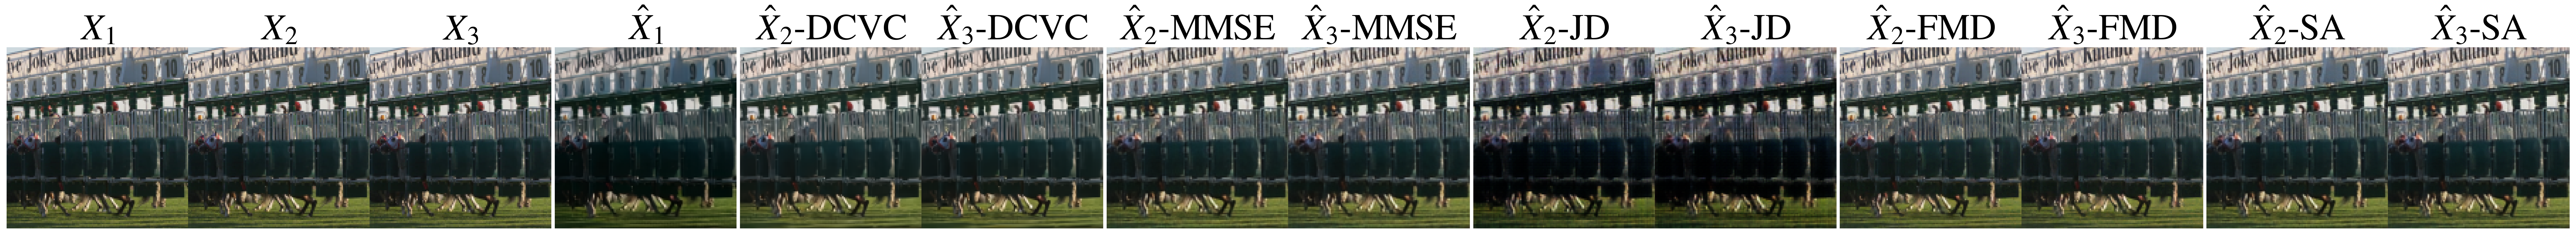

In [27]:
fig = plt.figure(dpi=250)
plt.rcParams.update({
    'font.family': 'FreeSerif',
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'FreeSerif',
    'mathtext.it': 'FreeSerif:italic',
    'mathtext.bf': 'FreeSerif:bold',
})

fig.set_size_inches(50, 20)

gs = gridspec.GridSpec(1, 20)
gs = gridspec.GridSpec(
    1, 20, 
    width_ratios=[1, 1, 1, 0.02, 
                  1, 0.02, 
                  1, 1, 0.02, 
                  1, 1, 0.02, 
                  1, 1, 0.02, 
                  1, 1, 0.02, 
                  1, 1]
)

positions = [0, 1, 2, 4, 6, 7, 9, 10, 12, 13, 15, 16, 18, 19]
axarr = [fig.add_subplot(gs[pos]) for pos in positions]

for ax in axarr:
    ax.axis('off')

fontsize = 40
axarr[0].set_title('$X_1$', fontsize=fontsize)
axarr[1].set_title('$X_2$', fontsize=fontsize)
axarr[2].set_title('$X_3$', fontsize=fontsize)
axarr[3].set_title('$\hat{X}_1$', fontsize=fontsize)
axarr[4].set_title('$\hat{X}_2$-DCVC', fontsize=fontsize)
axarr[5].set_title('$\hat{X}_3$-DCVC', fontsize=fontsize)
axarr[6].set_title('$\hat{X}_2$-MMSE', fontsize=fontsize)
axarr[7].set_title('$\hat{X}_3$-MMSE', fontsize=fontsize)
axarr[8].set_title('$\hat{X}_2$-JD', fontsize=fontsize)
axarr[9].set_title('$\hat{X}_3$-JD', fontsize=fontsize)
axarr[10].set_title('$\hat{X}_2$-FMD', fontsize=fontsize)
axarr[11].set_title('$\hat{X}_3$-FMD', fontsize=fontsize)
axarr[12].set_title('$\hat{X}_2$-SA', fontsize=fontsize)
axarr[13].set_title('$\hat{X}_3$-SA', fontsize=fontsize)

axarr[0].imshow(x1_img)
axarr[1].imshow(x2_img)
axarr[2].imshow(x3_img)

axarr[3].imshow(x1_hat_img)

# axarr[4].imshow(x2_hat_h264)
# axarr[5].imshow(x3_hat_h264)

axarr[4].imshow(x2_hat_dcvc)
axarr[5].imshow(x3_hat_dcvc)

axarr[6].imshow(x2_hat_MSE_img)
axarr[7].imshow(x3_hat_MSE_img)

axarr[8].imshow(x2_hat_JD_img)
axarr[9].imshow(x3_hat_JD_img)

axarr[10].imshow(x2_hat_FMD_img)
axarr[11].imshow(x3_hat_FMD_img)

axarr[12].imshow(x2_hat_AR_img)
axarr[13].imshow(x3_hat_AR_img)

plt.subplots_adjust(wspace=0.0)

letter = 'k'
os.makedirs(f'./reconstructions/R1-eps(uvg)/{letter}/', exist_ok=True)

plt.imsave(f"./reconstructions/R1-eps(uvg)/{letter}/x1.png", x1_img)
plt.imsave(f"./reconstructions/R1-eps(uvg)/{letter}/x2.png", x2_img)
plt.imsave(f"./reconstructions/R1-eps(uvg)/{letter}/x3.png", x3_img)
plt.imsave(f"./reconstructions/R1-eps(uvg)/{letter}/x1_hat.png", x1_hat_img)
plt.imsave(f"./reconstructions/R1-eps(uvg)/{letter}/x2_hat_JD.png", x2_hat_JD_img)
plt.imsave(f"./reconstructions/R1-eps(uvg)/{letter}/x2_hat_AR.png", x2_hat_AR_img)
plt.imsave(f"./reconstructions/R1-eps(uvg)/{letter}/x3_hat_JD.png", x3_hat_JD_img)
plt.imsave(f"./reconstructions/R1-eps(uvg)/{letter}/x3_hat_AR.png", x3_hat_AR_img)
plt.imsave(f"./reconstructions/R1-eps(uvg)/{letter}/x2_hat_DCVC.png", x2_hat_dcvc)
plt.imsave(f"./reconstructions/R1-eps(uvg)/{letter}/x3_hat_DCVC.png", x3_hat_dcvc)

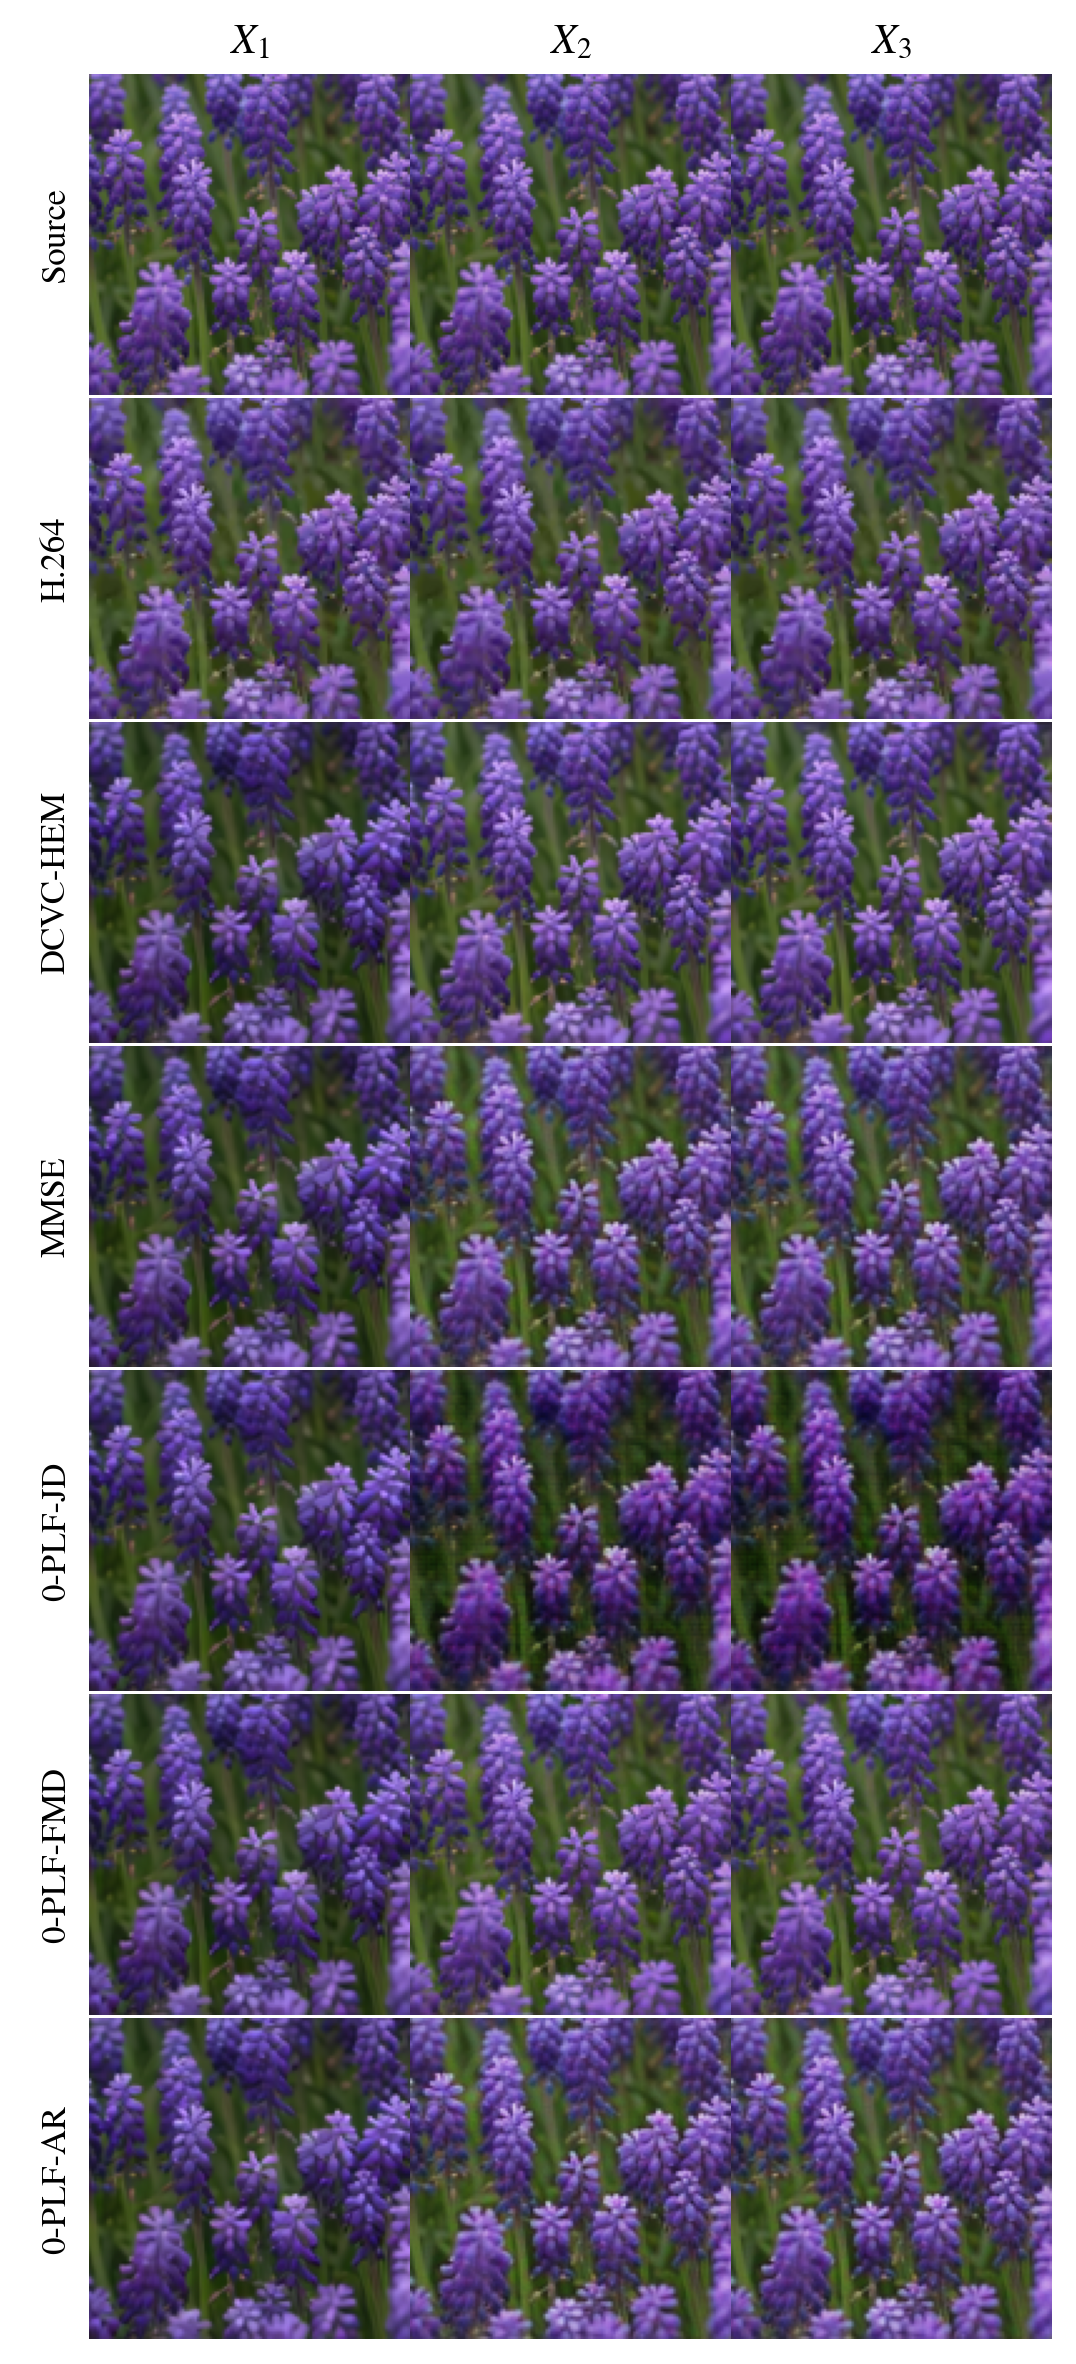

In [13]:
fig, axarr = plt.subplots(
    7, 4, dpi=250, 
    gridspec_kw={
        'wspace': 0.0, 'hspace': 0.01, 'width_ratios': [0.2, 1, 1, 1]}
)
fig.set_size_inches(5.3, 12)

for i in range(7):
    for j in range(4):
        axarr[i,j].axis('off')

axarr[0, 1].set_title(r"$X_1$")
axarr[0, 2].set_title(r"$X_2$")
axarr[0, 3].set_title(r"$X_3$")

axarr[0, 0].text(0.5, 0.5, r"Source", rotation=90, verticalalignment='center', 
                 horizontalalignment='center', transform=axarr[0, 0].transAxes)
axarr[1, 0].text(0.5, 0.5, r"H.264", rotation=90, verticalalignment='center', 
                 horizontalalignment='center', transform=axarr[1, 0].transAxes)
axarr[2, 0].text(0.5, 0.5, r"DCVC-HEM", rotation=90, verticalalignment='center', 
                 horizontalalignment='center', transform=axarr[2, 0].transAxes)
axarr[3, 0].text(0.5, 0.5, r"MMSE", rotation=90, verticalalignment='center', 
                 horizontalalignment='center', transform=axarr[3, 0].transAxes)
axarr[4, 0].text(0.5, 0.5, r"0-PLF-JD", rotation=90, verticalalignment='center', 
                 horizontalalignment='center', transform=axarr[4, 0].transAxes)
axarr[5, 0].text(0.5, 0.5, r"0-PLF-FMD", rotation=90, verticalalignment='center', 
                 horizontalalignment='center', transform=axarr[5, 0].transAxes)
axarr[6, 0].text(0.5, 0.5, r"0-PLF-AR", rotation=90, verticalalignment='center', 
                 horizontalalignment='center', transform=axarr[6, 0].transAxes)

axarr[0, 1].imshow(x1_img)
axarr[0, 2].imshow(x2_img)
axarr[0, 3].imshow(x3_img)

axarr[1, 1].imshow(x1_hat_h264)
axarr[1, 2].imshow(x2_hat_h264)
axarr[1, 3].imshow(x3_hat_h264)

axarr[2, 1].imshow(x1_hat_img)
axarr[2, 2].imshow(x2_hat_dcvc)
axarr[2, 3].imshow(x3_hat_dcvc)

axarr[3, 1].imshow(x1_hat_img)
axarr[3, 2].imshow(x2_hat_MSE_img)
axarr[3, 3].imshow(x3_hat_MSE_img)

axarr[4, 1].imshow(x1_hat_img)
axarr[4, 2].imshow(x2_hat_JD_img)
axarr[4, 3].imshow(x3_hat_JD_img)

axarr[5, 1].imshow(x1_hat_img)
axarr[5, 2].imshow(x2_hat_FMD_img)
axarr[5, 3].imshow(x3_hat_FMD_img)

axarr[6, 1].imshow(x1_hat_img)
axarr[6, 2].imshow(x2_hat_AR_img)
axarr[6, 3].imshow(x3_hat_AR_img)

letter = 'k'
os.makedirs(f'./reconstructions/R1-eps-uvg/{letter}/', exist_ok=True)

plt.imsave(f"./reconstructions/R1-eps-uvg/{letter}/x1.png", x1_img)
plt.imsave(f"./reconstructions/R1-eps-uvg/{letter}/x2.png", x2_img)
plt.imsave(f"./reconstructions/R1-eps-uvg/{letter}/x3.png", x3_img)
plt.imsave(f"./reconstructions/R1-eps-uvg/{letter}/x1_hat.png", x1_hat_img)
plt.imsave(f"./reconstructions/R1-eps-uvg/{letter}/x1_hat_h264.png", x1_hat_h264)
plt.imsave(f"./reconstructions/R1-eps-uvg/{letter}/x2_hat_h264.png", x2_hat_h264)
plt.imsave(f"./reconstructions/R1-eps-uvg/{letter}/x3_hat_h264.png", x3_hat_h264)
plt.imsave(f"./reconstructions/R1-eps-uvg/{letter}/x2_hat_DCVC.png", x2_hat_dcvc)
plt.imsave(f"./reconstructions/R1-eps-uvg/{letter}/x3_hat_DCVC.png", x3_hat_dcvc)
plt.imsave(f"./reconstructions/R1-eps-uvg/{letter}/x2_hat_JD.png", x2_hat_JD_img)
plt.imsave(f"./reconstructions/R1-eps-uvg/{letter}/x2_hat_AR.png", x2_hat_AR_img)
plt.imsave(f"./reconstructions/R1-eps-uvg/{letter}/x2_hat_FMD.png", x2_hat_FMD_img)
plt.imsave(f"./reconstructions/R1-eps-uvg/{letter}/x2_hat_MSE.png", x2_hat_MSE_img)
plt.imsave(f"./reconstructions/R1-eps-uvg/{letter}/x3_hat_JD.png", x3_hat_JD_img)
plt.imsave(f"./reconstructions/R1-eps-uvg/{letter}/x3_hat_AR.png", x3_hat_AR_img)
plt.imsave(f"./reconstructions/R1-eps-uvg/{letter}/x3_hat_FMD.png", x3_hat_FMD_img)
plt.imsave(f"./reconstructions/R1-eps-uvg/{letter}/x3_hat_MSE.png", x3_hat_MSE_img)

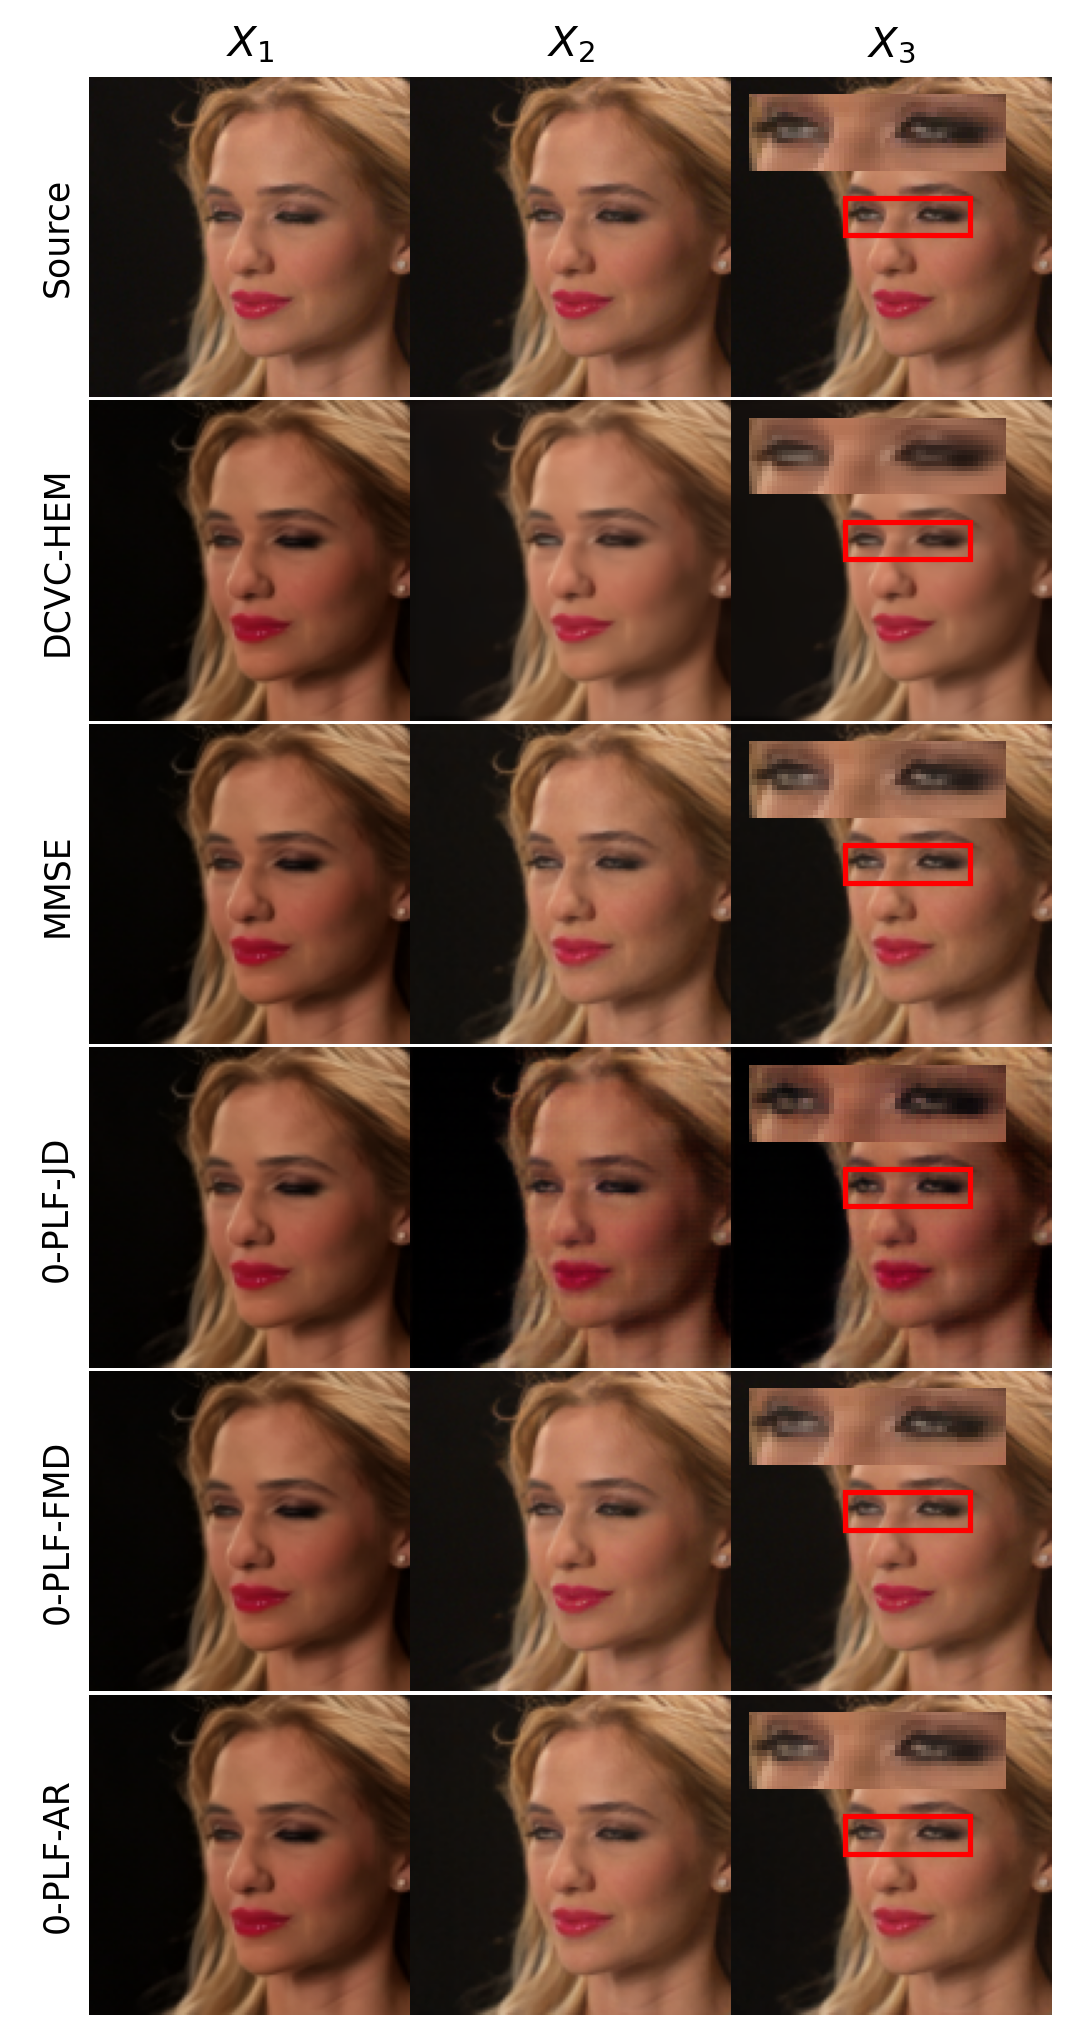

In [5]:
save_path = './reconstructions/R1-eps-uvg-pupil/k/'

x1_img = Image.open(save_path + "x1.png")
x2_img = Image.open(save_path + "x2.png")
x3_img = Image.open(save_path + "x3.png")
x1_hat_img = Image.open(save_path + "x1_hat.png")

# x1_hat_h264 = Image.open(save_path + "x1_hat_h264.png")
# x2_hat_h264 = Image.open(save_path + "x2_hat_h264.png")
# x3_hat_h264 = Image.open(save_path + "x3_hat_h264.png")

x2_hat_dcvc = Image.open(save_path + "x2_hat_DCVC.png")
x3_hat_dcvc = Image.open(save_path + "x3_hat_DCVC.png")

x2_hat_JD_img = Image.open(save_path + "x2_hat_JD.png")
x3_hat_JD_img = Image.open(save_path + "x3_hat_JD.png")
x2_hat_AR_img = Image.open(save_path + "x2_hat_AR.png")
x3_hat_AR_img = Image.open(save_path + "x3_hat_AR.png")
x2_hat_FMD_img = Image.open(save_path + "x2_hat_FMD.png")
x3_hat_FMD_img = Image.open(save_path + "x3_hat_FMD.png")
x2_hat_MSE_img = Image.open(save_path + "x2_hat_MSE.png")
x3_hat_MSE_img = Image.open(save_path + "x3_hat_MSE.png")

import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, axarr = plt.subplots(
    6, 4, dpi=250, 
    gridspec_kw={
        'wspace': 0.0, 'hspace': 0.01, 'width_ratios': [0.2, 1, 1, 1]}
)
fig.set_size_inches(5.3, 10.27)

for i in range(6):
    for j in range(4):
        axarr[i, j].axis('off')

axarr[0, 1].set_title(r"$X_1$")
axarr[0, 2].set_title(r"$X_2$")
axarr[0, 3].set_title(r"$X_3$")

axarr[0, 0].text(0.5, 0.5, r"Source", rotation=90, verticalalignment='center', 
                 horizontalalignment='center', transform=axarr[0, 0].transAxes)
# axarr[1, 0].text(0.5, 0.5, r"H.264", rotation=90, verticalalignment='center', 
#                  horizontalalignment='center', transform=axarr[1, 0].transAxes)
axarr[1, 0].text(0.5, 0.5, r"DCVC-HEM", rotation=90, verticalalignment='center', 
                 horizontalalignment='center', transform=axarr[1, 0].transAxes)
axarr[2, 0].text(0.5, 0.5, r"MMSE", rotation=90, verticalalignment='center', 
                 horizontalalignment='center', transform=axarr[2, 0].transAxes)
axarr[3, 0].text(0.5, 0.5, r"0-PLF-JD", rotation=90, verticalalignment='center', 
                 horizontalalignment='center', transform=axarr[3, 0].transAxes)
axarr[4, 0].text(0.5, 0.5, r"0-PLF-FMD", rotation=90, verticalalignment='center', 
                 horizontalalignment='center', transform=axarr[4, 0].transAxes)
axarr[5, 0].text(0.5, 0.5, r"0-PLF-AR", rotation=90, verticalalignment='center', 
                 horizontalalignment='center', transform=axarr[5, 0].transAxes)

images = [
    [x1_img, x2_img, x3_img],
    [x1_hat_img, x2_hat_dcvc, x3_hat_dcvc],
    [x1_hat_img, x2_hat_MSE_img, x3_hat_MSE_img],
    [x1_hat_img, x2_hat_JD_img, x3_hat_JD_img],
    [x1_hat_img, x2_hat_FMD_img, x3_hat_FMD_img],
    [x1_hat_img, x2_hat_AR_img, x3_hat_AR_img],
]

for i, image_row in enumerate(images):
    for j, img in enumerate(image_row):
        axarr[i, j + 1].imshow(img)

    rect_x, rect_y, rect_width, rect_height = 45, 48, 50, 15
    rect = patches.Rectangle((rect_x, rect_y), rect_width, rect_height, 
                             linewidth=1.5, edgecolor='red', facecolor='none')
    
    axarr[i, 3].add_patch(rect)

    inset_ax = inset_axes(axarr[i, 3], width="80%", height="24%", loc=2)
    inset_ax.imshow(image_row[2])
    inset_ax.set_xlim(rect_x, rect_x + rect_width)
    inset_ax.set_ylim(rect_y + rect_height, rect_y)
    inset_ax.axis('off')

plt.show()

In [36]:
mse_eval = {'2_psnr':[], '3_psnr': [], '2_ssim': [], '3_ssim': []}
jd_eval =  {'2_psnr':[], '3_psnr': [], '2_ssim': [], '3_ssim': []}
fmd_eval = {'2_psnr':[], '3_psnr': [], '2_ssim': [], '3_ssim': []}
ar_eval =  {'2_psnr':[], '3_psnr': [], '2_ssim': [], '3_ssim': []}
dcvc_eval = {'2_psnr':[], '3_psnr': [], '2_ssim': [], '3_ssim': []}

dcvc_bbp_x2 = []
dcvc_bbp_x3 = []

length = 200
test_loader = itertools.islice(uvg_dataloader, length)

ssf_JD.eval()
ssf_AR.eval()
ssf_MSE.eval()
fmd.eval()

for data in tqdm(test_loader):
    with torch.no_grad():
        x = data[:, :4, ...].to(device)
        # x1 = 2 * (data[:, 0, ...] - 0.5).to(device)
        x2 = 2 * (data[:, 1, ...] - 0.5).to(device) # [-1, 1]
        x3 = 2 * (data[:, 2, ...] - 0.5).to(device)
        x1_hat = 2 * (data[:, 3, ...] - 0.5).to(device)

        x2_hat_JD = ssf_JD([x1_hat, x2])
        x2_hat_AR = ssf_AR([x1_hat, x2])
        # x2_hat_AR = (x2_hat_AR - x2_hat_AR.min()) / (x2_hat_AR.max() - x2_hat_AR.min())
        x2_hat_MSE = ssf_MSE([x1_hat, x2])

        x3_hat_JD = ssf_JD([x2_hat_JD, x3])
        x3_hat_AR = ssf_AR([x2_hat_AR, x3])
        # x3_hat_AR = (x3_hat_AR - x3_hat_AR.min()) / (x3_hat_AR.max() - x3_hat_AR.min())
        x3_hat_MSE = ssf_MSE([x2_hat_MSE, x3])

        x2_hat_FMD, _ = fmd(x2)
        x3_hat_FMD, _ = fmd(x3)

        x2_hat_dcvc, x3_hat_dcvc, bbp_x2, bbp_x3 = run_dcvc_test(x, rate_idx=3)
        dcvc_bbp_x2.append(bbp_x2)
        dcvc_bbp_x3.append(bbp_x3)

        mse_eval['2_psnr'].append(PSNR(x2, x2_hat_MSE))
        mse_eval['3_psnr'].append(PSNR(x3, x3_hat_MSE))
        mse_eval['2_ssim'].append(LPIPS(x2, x2_hat_MSE))
        mse_eval['3_ssim'].append(LPIPS(x3, x3_hat_MSE))

        jd_eval['2_psnr'].append(PSNR(x2, x2_hat_JD))
        jd_eval['3_psnr'].append(PSNR(x2, x3_hat_JD))
        jd_eval['2_ssim'].append(LPIPS(x2, x2_hat_JD))
        jd_eval['3_ssim'].append(LPIPS(x3, x3_hat_JD))

        fmd_eval['2_psnr'].append(PSNR(x2, 2 * x2_hat_FMD - 1.))
        fmd_eval['3_psnr'].append(PSNR(x3, 2 * x3_hat_FMD - 1.))
        fmd_eval['2_ssim'].append(LPIPS(x2, 2 * x2_hat_FMD - 1.))
        fmd_eval['3_ssim'].append(LPIPS(x3, 2 * x3_hat_FMD - 1.))

        ar_eval['2_psnr'].append(PSNR(x2, x2_hat_AR))
        ar_eval['3_psnr'].append(PSNR(x3, x3_hat_AR))
        ar_eval['2_ssim'].append(LPIPS(x2, x2_hat_AR))
        ar_eval['3_ssim'].append(LPIPS(x3, x3_hat_AR))

        dcvc_eval['2_psnr'].append(PSNR(x2, 2 * x2_hat_dcvc - 1.))
        dcvc_eval['3_psnr'].append(PSNR(x3, 2 * x3_hat_dcvc - 1.))
        dcvc_eval['2_ssim'].append(LPIPS(x2, 2 * x2_hat_dcvc - 1.))
        dcvc_eval['3_ssim'].append(LPIPS(x3, 2 * x3_hat_dcvc - 1.))

avg_bbp_2 = sum(dcvc_bbp_x2) / len(dcvc_bbp_x2)
avg_bbp_3 = sum(dcvc_bbp_x3) / len(dcvc_bbp_x3)
print(f"DCVC avg bit 2 frame: {avg_bbp_2}")
print(f"DCVC avg bit 3 frame: {avg_bbp_3}")

def compute_stats(eval_dict):
    stats = {}
    for key, values in eval_dict.items():
        values = np.array(values)
        mean_val = np.mean(values)
        std_val = np.std(values)
        max_val = np.max(values)
        min_val = np.min(values)
        stats[key] = (mean_val, std_val, max_val, min_val)  # Normalize by length
    return stats

# Compute statistics for each evaluation method
mse_stats = compute_stats(mse_eval)
jd_stats = compute_stats(jd_eval)
fmd_stats = compute_stats(fmd_eval)
ar_stats = compute_stats(ar_eval)
dcvc_stats = compute_stats(dcvc_eval)

# Print formatted results
print('Second frame PSNR:    ' + # f'MSE {mse_stats["2_psnr"][0]:.4f}±{mse_stats["2_psnr"][1]:.4f} | ' +
      f'JD {jd_stats["2_psnr"][0]:.4f} | ' +
      f'FMD {fmd_stats["2_psnr"][0]:.4f} | ' +
      f'AR {ar_stats["2_psnr"][0]:.4f} | ' +
      f'DCVC {dcvc_stats["2_psnr"][0]:.4f}')

print('Second frame MS-SSIM: ' + # f'MSE {mse_stats["2_ssim"][0]:.4f}±{mse_stats["2_ssim"][1]:.4f} | ' +
      f'JD {jd_stats["2_ssim"][0]:.4f} | ' +
      f'FMD {fmd_stats["2_ssim"][0]:.4f} | ' +
      f'AR {ar_stats["2_ssim"][0]:.4f} | ' +
      f'DCVC {dcvc_stats["2_ssim"][0]:.4f}')

print('Third frame PSNR:     ' + # f'MSE {mse_stats["3_psnr"][0]:.4f}±{mse_stats["3_psnr"][1]:.4f} | ' +
      f'JD {jd_stats["3_psnr"][0]:.4f} | ' +
      f'FMD {fmd_stats["3_psnr"][0]:.4f} | ' +
      f'AR {ar_stats["3_psnr"][0]:.4f} | ' +
      f'DCVC {dcvc_stats["3_psnr"][0]:.4f}')

print('Third frame MS-SSIM:  ' + # f'MSE {mse_stats["3_ssim"][0]:.4f}±{mse_stats["3_ssim"][1]:.4f} | ' +
      f'JD {jd_stats["3_ssim"][0]:.4f} | ' +
      f'FMD {fmd_stats["3_ssim"][0]:.4f} | ' +
      f'AR {ar_stats["3_ssim"][0]:.4f} | ' +
      f'DCVC {dcvc_stats["3_ssim"][0]:.4f}')


200it [03:09,  1.05it/s]

DCVC avg bit 2 frame: 26066.736337890627
DCVC avg bit 3 frame: 16789.45491699219
Second frame PSNR:    JD 15.8973 | FMD 26.9082 | AR 28.2956 | DCVC 28.1054
Second frame MS-SSIM: JD 0.1357 | FMD 0.0208 | AR 0.0556 | DCVC 0.0392
Third frame PSNR:     JD 14.5547 | FMD 26.8931 | AR 28.1129 | DCVC 28.7367
Third frame MS-SSIM:  JD 0.1384 | FMD 0.0208 | AR 0.0582 | DCVC 0.0280


In [10]:
### Evaluate FVD
mse_eval = {'2_psnr':[], '3_psnr': [], '2_ssim': [], '3_ssim': []}
jd_eval =  {'2_psnr':[], '3_psnr': [], '2_ssim': [], '3_ssim': []}
fmd_eval = {'2_psnr':[], '3_psnr': [], '2_ssim': [], '3_ssim': []}
ar_eval =  {'2_psnr':[], '3_psnr': [], '2_ssim': [], '3_ssim': []}
dcvc_eval = {'2_psnr':[], '3_psnr': [], '2_ssim': [], '3_ssim': []}

dcvc_bbp_x2 = []
dcvc_bbp_x3 = []

length = 200
test_loader = itertools.islice(uvg_dataloader, length)

ssf_JD.eval()
ssf_AR.eval()
ssf_MSE.eval()
fmd.eval()

for data in tqdm(test_loader):
    with torch.no_grad():
        x = data[:, :4, ...].to(device)
        # x1 = 2 * (data[:, 0, ...] - 0.5).to(device)
        x2 = 2 * (data[:, 1, ...] - 0.5).to(device) # [-1, 1]
        x3 = 2 * (data[:, 2, ...] - 0.5).to(device)
        x1_hat = 2 * (data[:, 3, ...] - 0.5).to(device)

        x2_hat_JD = ssf_JD([x1_hat, x2])
        x2_hat_AR = ssf_AR([x1_hat, x2])
        # x2_hat_AR = (x2_hat_AR - x2_hat_AR.min()) / (x2_hat_AR.max() - x2_hat_AR.min())
        x2_hat_MSE = ssf_MSE([x1_hat, x2])

        x3_hat_JD = ssf_JD([x2_hat_JD, x3])
        x3_hat_AR = ssf_AR([x2_hat_AR, x3])
        # x3_hat_AR = (x3_hat_AR - x3_hat_AR.min()) / (x3_hat_AR.max() - x3_hat_AR.min())
        x3_hat_MSE = ssf_MSE([x2_hat_MSE, x3])

        x2_hat_FMD, _ = fmd(x2)
        x3_hat_FMD, _ = fmd(x3)

        x2_hat_dcvc, x3_hat_dcvc, bbp_x2, bbp_x3 = run_dcvc_test(x, rate_idx=3)
        dcvc_bbp_x2.append(bbp_x2)
        dcvc_bbp_x3.append(bbp_x3)

        mse_eval['2_psnr'].append(PSNR(x2, x2_hat_MSE))
        mse_eval['3_psnr'].append(PSNR(x3, x3_hat_MSE))
        mse_eval['2_ssim'].append(LPIPS(x2, x2_hat_MSE))
        mse_eval['3_ssim'].append(LPIPS(x3, x3_hat_MSE))

        jd_eval['2_psnr'].append(PSNR(x2, x2_hat_JD))
        jd_eval['3_psnr'].append(PSNR(x2, x3_hat_JD))
        jd_eval['2_ssim'].append(LPIPS(x2, x2_hat_JD))
        jd_eval['3_ssim'].append(LPIPS(x3, x3_hat_JD))

        fmd_eval['2_psnr'].append(PSNR(x2, 2 * x2_hat_FMD - 1.))
        fmd_eval['3_psnr'].append(PSNR(x3, 2 * x3_hat_FMD - 1.))
        fmd_eval['2_ssim'].append(LPIPS(x2, 2 * x2_hat_FMD - 1.))
        fmd_eval['3_ssim'].append(LPIPS(x3, 2 * x3_hat_FMD - 1.))

        ar_eval['2_psnr'].append(PSNR(x2, x2_hat_AR))
        ar_eval['3_psnr'].append(PSNR(x3, x3_hat_AR))
        ar_eval['2_ssim'].append(LPIPS(x2, x2_hat_AR))
        ar_eval['3_ssim'].append(LPIPS(x3, x3_hat_AR))

        dcvc_eval['2_psnr'].append(PSNR(x2, 2 * x2_hat_dcvc - 1.))
        dcvc_eval['3_psnr'].append(PSNR(x3, 2 * x3_hat_dcvc - 1.))
        dcvc_eval['2_ssim'].append(LPIPS(x2, 2 * x2_hat_dcvc - 1.))
        dcvc_eval['3_ssim'].append(LPIPS(x3, 2 * x3_hat_dcvc - 1.))

avg_bbp_2 = sum(dcvc_bbp_x2) / len(dcvc_bbp_x2)
avg_bbp_3 = sum(dcvc_bbp_x3) / len(dcvc_bbp_x3)
print(f"DCVC avg bit 2 frame: {avg_bbp_2}")
print(f"DCVC avg bit 3 frame: {avg_bbp_3}")

def compute_stats(eval_dict):
    stats = {}
    for key, values in eval_dict.items():
        values = np.array(values)
        mean_val = np.mean(values)
        std_val = np.std(values)
        max_val = np.max(values)
        min_val = np.min(values)
        stats[key] = (mean_val, std_val, max_val, min_val)  # Normalize by length
    return stats

# Compute statistics for each evaluation method
mse_stats = compute_stats(mse_eval)
jd_stats = compute_stats(jd_eval)
fmd_stats = compute_stats(fmd_eval)
ar_stats = compute_stats(ar_eval)
dcvc_stats = compute_stats(dcvc_eval)

# Print formatted results
print('Second frame PSNR:    ' + # f'MSE {mse_stats["2_psnr"][0]:.4f}±{mse_stats["2_psnr"][1]:.4f} | ' +
      f'JD {jd_stats["2_psnr"][0]:.4f} | ' +
      f'FMD {fmd_stats["2_psnr"][0]:.4f} | ' +
      f'AR {ar_stats["2_psnr"][0]:.4f} | ' +
      f'DCVC {dcvc_stats["2_psnr"][0]:.4f}')

print('Second frame MS-SSIM: ' + # f'MSE {mse_stats["2_ssim"][0]:.4f}±{mse_stats["2_ssim"][1]:.4f} | ' +
      f'JD {jd_stats["2_ssim"][0]:.4f} | ' +
      f'FMD {fmd_stats["2_ssim"][0]:.4f} | ' +
      f'AR {ar_stats["2_ssim"][0]:.4f} | ' +
      f'DCVC {dcvc_stats["2_ssim"][0]:.4f}')

print('Third frame PSNR:     ' + # f'MSE {mse_stats["3_psnr"][0]:.4f}±{mse_stats["3_psnr"][1]:.4f} | ' +
      f'JD {jd_stats["3_psnr"][0]:.4f} | ' +
      f'FMD {fmd_stats["3_psnr"][0]:.4f} | ' +
      f'AR {ar_stats["3_psnr"][0]:.4f} | ' +
      f'DCVC {dcvc_stats["3_psnr"][0]:.4f}')

print('Third frame MS-SSIM:  ' + # f'MSE {mse_stats["3_ssim"][0]:.4f}±{mse_stats["3_ssim"][1]:.4f} | ' +
      f'JD {jd_stats["3_ssim"][0]:.4f} | ' +
      f'FMD {fmd_stats["3_ssim"][0]:.4f} | ' +
      f'AR {ar_stats["3_ssim"][0]:.4f} | ' +
      f'DCVC {dcvc_stats["3_ssim"][0]:.4f}')
